Tác giả: [ProtonX Team](https://protonx.io/)

In [1]:
!pip -q install langchain-core langchain-community langgraph langchain-openai duckduckgo-search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.6 MB/s eta 0:00:00


In [2]:
## Traditional ReAct


react_prompt = """Assistant is a large language model trained by Microsoft.

Assistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

Assistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on a wide range of topics.

Overall, Assistant is a powerful tool that can help with a wide range of tasks and provide valuable insights and information on a wide range of topics. Whether you need help with a specific question or just want to have a conversation about a particular topic, Assistant is here to assist.

TOOLS:
------

Assistant has access to the following tools:

web_search - searches the web for the answer\n
calculator - calculates the answer to the question\n


To use a tool, please use the following format:

```
Thought: Do I need to use a tool? Yes
Action: the action to take, should be one of [web_search, calculator]
Action Input: the input to the action
Observation: the result of the action
```

When you have a response to say to the Human, or if you do not need to use a tool, you MUST use the format:

```
Thought: Do I need to use a tool? No
Final Answer: [your response here]
```

Begin!


New input: Cách nấu phở ngon
"""

In [4]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('open_ai_key')


SecretNotFoundError: Secret open_ai_key does not exist.

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [ ]:
# This will be a tool
def multiply(a: float, b: float) -> float:
    """Multiply a and b.

    Args:
        a: first float
        b: second float
    """
    return a * b


def add(a: float, b: float) -> float:
    """Adds a and b.

    Args:
        a: first float
        b: second float
    """
    return a + b

In [ ]:
# search tools
from langchain_community.tools import GoogleSearchResults

search = DuckDuckGoSearchRun()

search.invoke("Cách nấu phở ngon")

In [ ]:
tools = [add, multiply, search]

llm_with_tools = llm.bind_tools(tools)

In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")



In [ ]:
# Node
def reasoner(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition # this is the checker for the if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)
builder.add_node("tools", ToolNode(tools)) # for the tools

# Add edges
builder.add_edge(START, "reasoner")
builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

# Display the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
messages = [HumanMessage(content="Tuổi của Nguyễn Trãi x 2 + tuổi của Nguyễn Nhạc")]
messages = react_graph.invoke({"messages": messages})

In [ ]:
for m in messages['messages']:
    m.pretty_print()

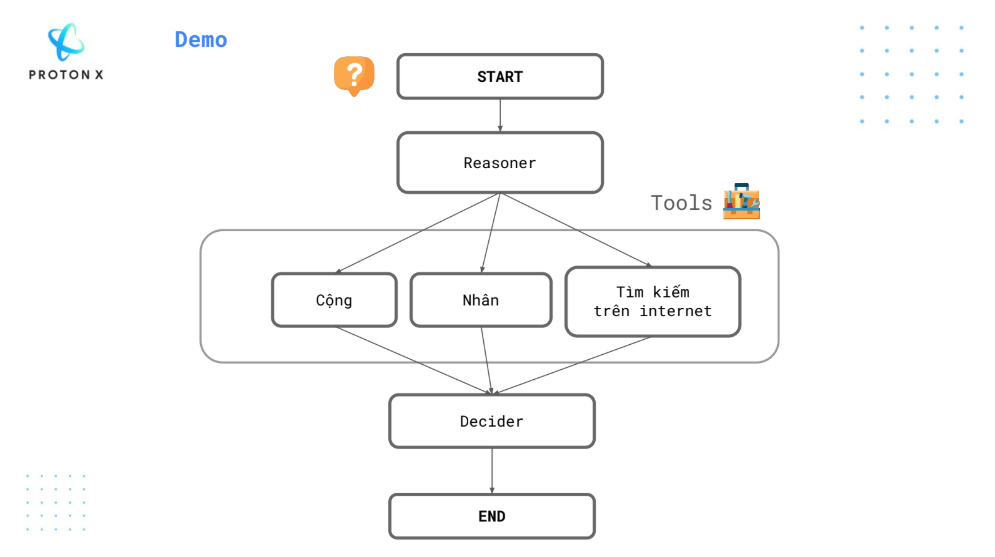